# A background elimination method based on linear programming for Raman spectra 

In this notebook we are trying to reproduce the background elimination technique described in the article of Sung-June Baek, Aaron Park, Aigou Shen, Jiming Hu: https://doi.org/10.1016/j.chemolab.2009.04.007.

### Settings and functions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import linprog
%matplotlib inline
font = {'size': 15}

In [3]:
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel(r"Raman shift [$cm^{-1}$]",fontsize=18)
    plt.ylabel("Intensity [a.u.]",fontsize=18)

In [4]:
def define_names(r=11,c=11):
    """
    Funzione che definisce i nomi delle coordinate degli spettri sul sample. I nomi sono del tipo r1c1,r1c2, ecc.
    Come default usa 11 colonne e 11 righe. Il primo nome è wn, che sta per wave number.
    """
    #definisco i nomi da assegnare ai punti delli spettri di sampling
    #wn -> wave number  r -> row c -> columns
    names = ['wn']+[f'r{k}c{i}' for k in range(1,r+1) for i in range(1,c+1)]
    return names

In [5]:
def interpol(S):
    min = int(S[0][0]) if S[0][0]==0 else int(S[0][0]) +1
    max = int(S[0][-1])
    X = np.arange(min,max+1,1)
    S = np.array([X, np.interp(X,S[0],S[1])])
    return S

In [6]:
def _raman_labels():
    plt.figure(figsize=(10,5))
    plt.xlabel(r'Raman shift [$cm^{-1}$]')
    plt.ylabel('Counts')

def plot(S):
    S = type2spectra(S)
    _raman_labels()
    if type(S)!=list:
        plt.plot(S[0], S[1])
    else:
        for s in S:
            plt.plot(s[0], s[1], label='')
    plt.show(block=False)

## Import of some test spectra
Here we import a few spectra on which to test this background-elimination technique. Then we chose one among these in the variable *col* on which the procedure is performed, change that variable to change the test-spectrum.

In [7]:
# open txt file with numpy array
n=11

temp = np.loadtxt('./data/S1_mapA_11x11.txt')
wn = temp[:,0]
data = np.zeros((n,n,len(wn)))
for i in range(n):
    for j in range(n):
        data[i,j,:] = temp[:,1+i*n+j]

# The procedure

The first step is the spectrum interpolation. This is something we do for each used spectrum just for simplicity. As can be seen from the plot there is absolutely no differences in the shape of the original spectrum and the interpolated one.

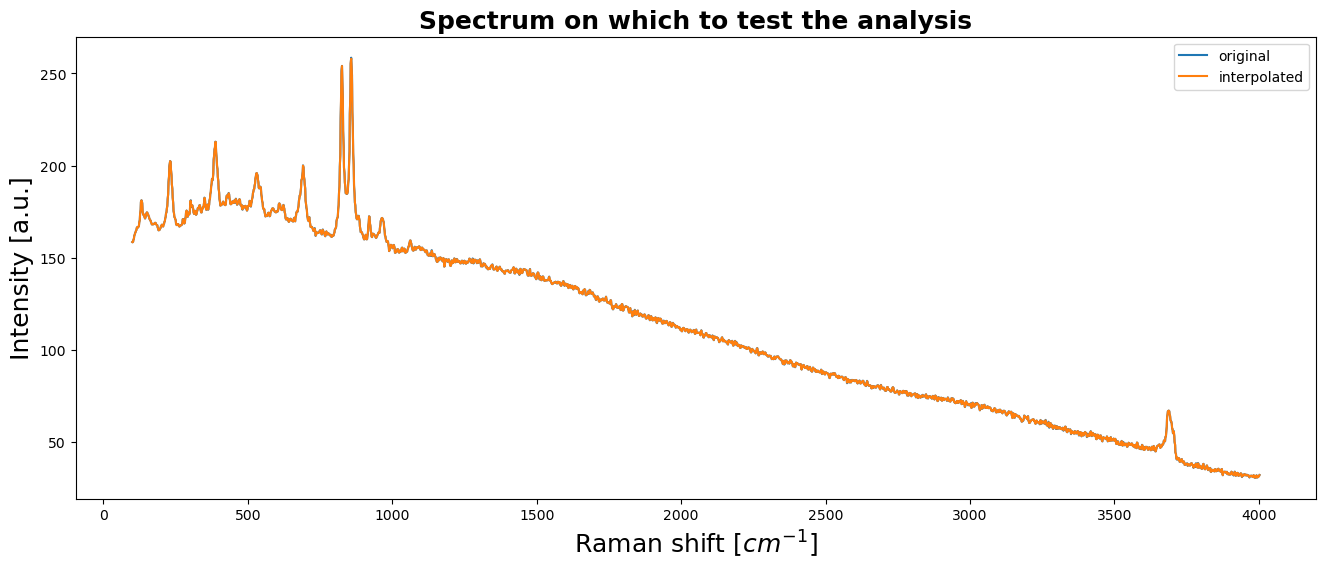

In [8]:
S = np.array([wn,data[10,10]])

raman_plot()
plt.plot(S[0],S[1], label = 'original')
S=interpol(S)
plt.plot(S[0],S[1], label = 'interpolated')
plt.title('Spectrum on which to test the analysis',fontsize=18,fontweight='bold')
plt.legend()

## Noise removal
Apply Savitzky–Golay ﬁlter with span $L_n$ to the given spectrum. The degree of a polynomial is set to 2. In the following, $s$ denotes the noise removed data. It doesn't matter if the peaks are distorted since we are interested in the background.

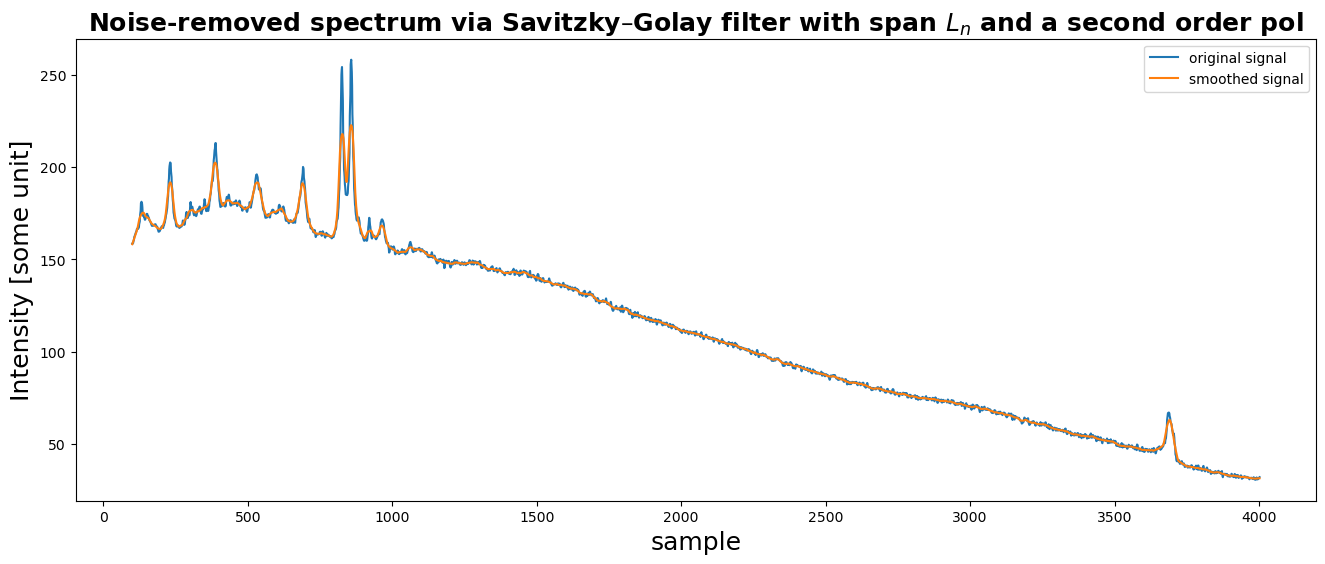

In [11]:
#############################################################################################
L_n=21                                       #lenght of smoothing filter for noise removal  #
pol_degree=1                                                                                 #
#############################################################################################
S_smooth = S.copy()
S_smooth[1]=savgol_filter(S[1],L_n,pol_degree)

plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("Intensity [some unit]",fontsize=18)
plt.title('Noise-removed spectrum via Savitzky–Golay filter with span $L_n$ and a second order pol',fontsize=18,fontweight='bold')
plt.plot(S[0],S[1], label='original signal')
plt.plot(S_smooth[0],S_smooth[1], label='smoothed signal')
plt.legend()

# Polynomial fitting with constrains => Linear programming
1. devo mantenere lo spettro non troppo largo, altrimenti numericamente non si riesce a trovare una soluzione!

sum(Y-XW) =  -424153.25110042095
status =  0
message =  Optimization terminated successfully. (HiGHS Status 7: Optimal)
# of iter =  99


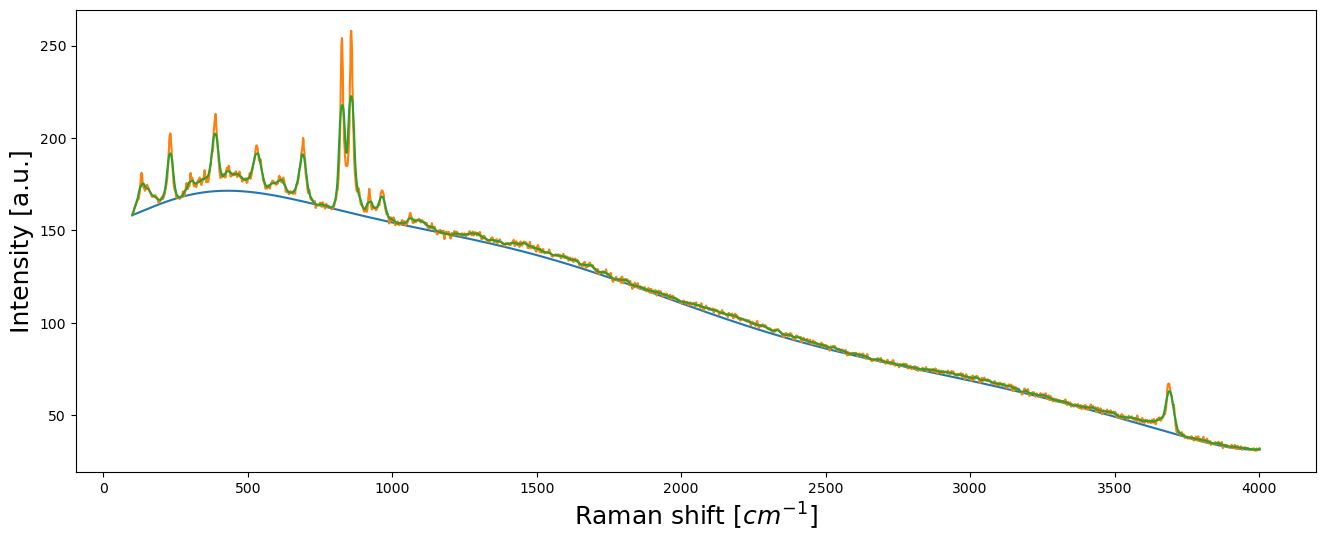

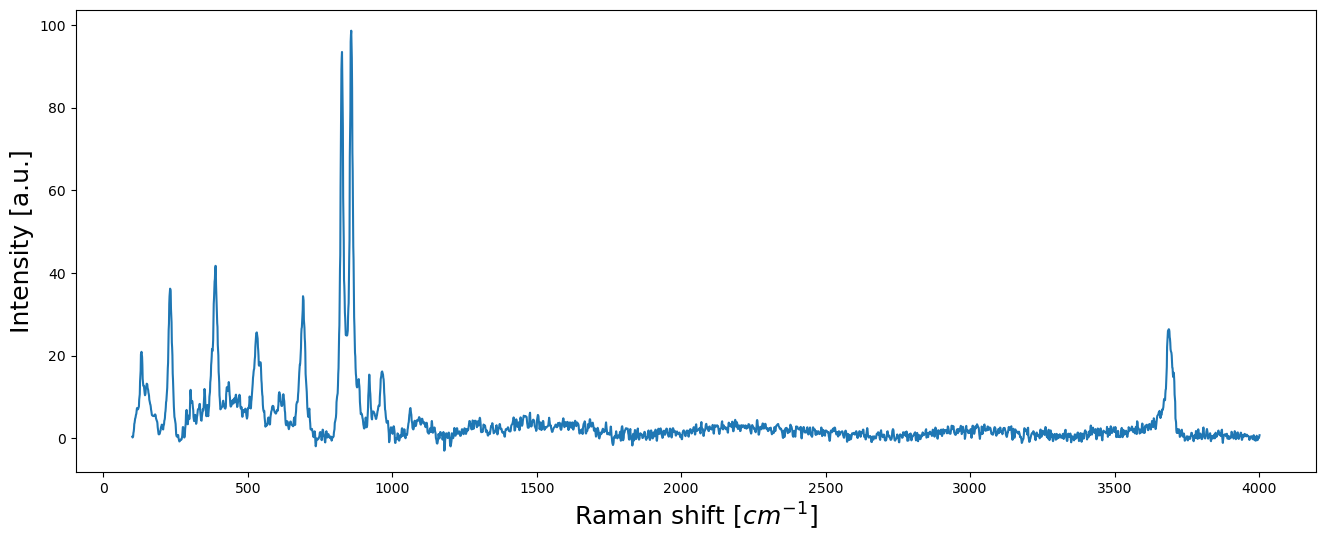

In [13]:
p= 11   # polinomial order
edge_width = 20 # this is for the edge problem of polinomial fitting
edge_weight = 2

#############################################################
# vector/matrice Y and X
Y = S_smooth[1]
x = S_smooth[0]
x = (x-x[0])/(x[-1]-x[0])
X = np.zeros((len(x),p))
for i in range(p):
   X[:, i] = x**i

# vector C
H = np.concatenate((np.ones(edge_width)*edge_weight, np.ones(X.shape[0]-2*edge_width), np.ones(edge_width)*edge_weight))
C = - np.dot(H,X)

# solving the linear programming problem
res = linprog(C, A_ub=X, b_ub = Y, bounds = (None, None), method='highs-ds')
W = res['x']
print('sum(Y-XW) = ', res['fun'])
print('status = ', res['status'])
print('message = ', res['message'])
print('# of iter = ', res['nit'])

# generate the BKG
x = S[0]
x = (x-x[0])/(x[-1]-x[0])
X = np.zeros((len(x),p))
for i in range(p):
   X[:, i] = x**i
BKG = np.dot(X,W)
raman_plot()
plt.plot(S[0], BKG)
plt.plot(S[0],S[1])
plt.plot(S_smooth[0],S_smooth[1])


raman_plot()
plt.plot(S[0],S[1]-BKG)

## We have to perform this on different sections of the spectra

In [14]:
S=S # SIGNAL
# 1) the signal must be already smoothed!
# 2) the signal must not be too large!

p= 11   # polinomial order
edge_width = 10 # this is for the edge problem of polinomial fitting
edge_weight = 2

#############################################################
def bkg_fit(S, p, edge_width=20, edge_weight=2, plot=False, verbose=False):
    # vector/matrice Y and X
    Y = S[1]
    x = S[0]
    x = (x-x[0])/(x[-1]-x[0])
    X = np.zeros((len(x),p))
    for i in range(p):
        X[:, i] = x**i

    # vector C
    H = np.concatenate((np.ones(edge_width)*edge_weight, np.ones(X.shape[0]-2*edge_width), np.ones(edge_width)*edge_weight))
    C = - np.dot(H,X)

    # solving the linear programming problem
    res = linprog(C, A_ub=X, b_ub = Y, bounds = (None, None), method='highs-ds')
    W = res['x']
    stat = res['status']
    if verbose == True:
        print('sum(Y-XW) = ', res['fun'])
        print('status = ', res['status'])
        print('message = ', res['message'])
        print('# of iter = ', res['nit'])

    if stat==0:    
        # generate the BKG
        x = S[0]
        x = (x-x[0])/(x[-1]-x[0])
        X = np.zeros((len(x),p))
        for i in range(p):
            X[:, i] = x**i
        BKG = np.dot(X,W)

        if plot==True:
            raman_plot()
            plt.plot(S[0], BKG, label='Estimated background')
            plt.plot(S[0],S[1], label='Original signal')
    
        return np.array([S[0],BKG]), stat
    else:
        return 0, stat

# example: BKG, stat = bkg_fit(S_smooth, 11, edge_width=20, edge_weight=2, plot=True)

def bkg_full_fit(S, p=11, edge_width=20, edge_weight=2, L_n=41, plot=False):
    # SMOOTHING
    S_smooth = S.copy()
    S_smooth[1]=savgol_filter(S[1],L_n,2)

    if plot==True:
        plt.figure(figsize=(16,6))
        plt.xlabel("sample",fontsize=18)
        plt.ylabel("Intensity [some unit]",fontsize=18)
        plt.plot(S[0],S[1], label='Original signal')
        plt.plot(S_smooth[0],S_smooth[1], label='Smoothed signal')
    
    # SEGMENTED FIT
    length = S_smooth.shape[1]
    bounds = []
    i=0
    while i<length:
        if i+1100<=length:
            i+=1100
            bounds.append([i-1100,i])
            i-=200
        else:
            i+=1100  
            bounds.append([length-1100,length])
    
    BKG=[]
    for i in bounds:
        BKG_temp, stat = bkg_fit(S_smooth[:,i[0]:i[1]], p, edge_width, edge_weight)
        if stat != 0:
            print('Fit do not converged, try smaller p!')
            return
        BKG.append(BKG_temp)

    if plot==True:
        #raman_plot()
        for i in BKG:
            plt.plot(i[0], i[1])
        plt.plot(S[0],S[1])

    #L'UNIONE SI PUO RIFARE SICURAMENTE IN MODO PIU PULITO
    BKG_final=BKG[0][:,0:1100-edge_width]
    for i in BKG[1:-1]:
        BKG_final = np.append(BKG_final,i[:,edge_width:-edge_width],axis=1)
        
    last = length%(len(bounds)-1)+200-edge_width
    BKG_final = np.append(BKG_final,BKG[-1][:,last:],axis=1)

    sorted_index = BKG_final[0].argsort()
    BKG_final = np.array([np.take_along_axis(BKG_final[0], sorted_index, axis=0),np.take_along_axis(BKG_final[1], sorted_index, axis=0)]) 

    BKG_final[1]=savgol_filter(BKG_final[1],L_n,2)
    BKG_final[1]=savgol_filter(BKG_final[1],L_n*2+1,2)
    BKG_final[1]=savgol_filter(BKG_final[1],L_n*3,2)

    #si puo fare sicuramente piu pulito
    BKG_final = np.array([np.unique(BKG_final[0]), np.interp(np.unique(BKG_final[0]), BKG_final[0], BKG_final[1])])
    
    if plot==True:
        plt.plot(BKG_final[0],BKG_final[1],label='Estimated background')
        plt.legend()

    return BKG_final

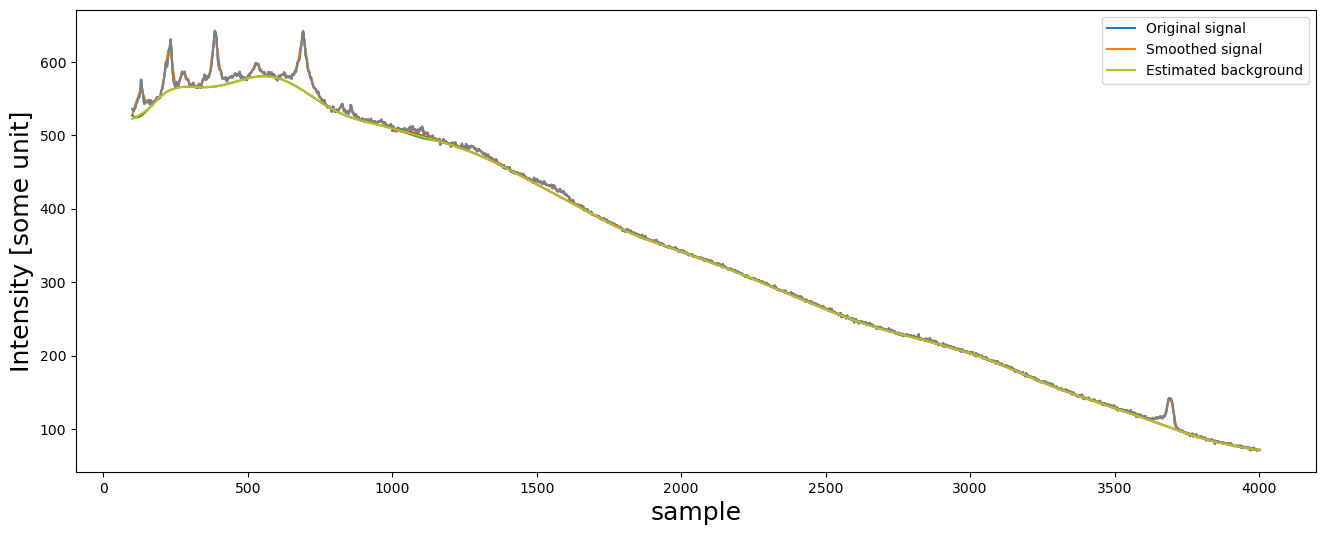

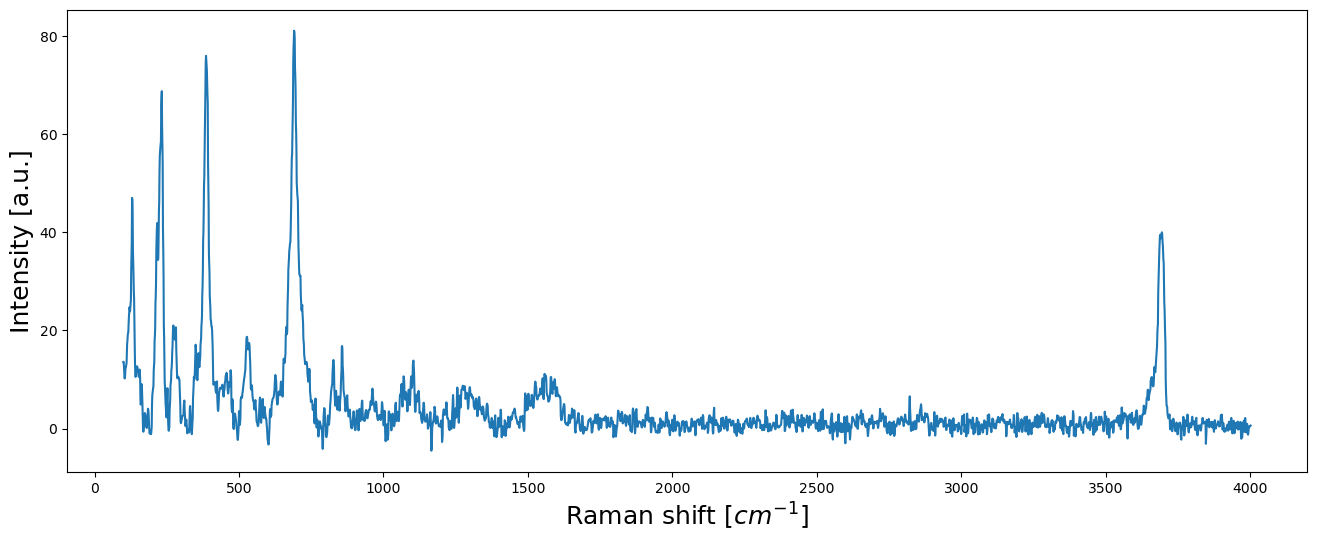

In [15]:
#col= 'r4c3'
#'r5c7'  
#'r5c2' bello
#'r1c3' brutto ma comunque dai
S = np.array([wn,data[5,2]])

S=interpol(S)
S=S
BKG=bkg_full_fit(S, p=10, edge_width=50, edge_weight=2, L_n=41, plot=True)

raman_plot()
plt.plot(S[0],S[1]-BKG[1])